# <center> Time Series Forecasting using Facebook Prophet

# Dataset
> The data is collected from PJM(Pennsylvenia, New Jersey and Maryland). 
<br>The dataset consists of Hourly power consumption data of PJM. <br>
Energy consumption has some special characteristics and depends on several factors which may include:
>> 1. Increase in population over a period of time increases the use of electricity.
2. Sudden change in climate raise the requirement for power.
3. Natural Calamity may reduce the power consumption as there will surely  be a power failure due to the calamity.
4. Especially the holidays and weekends even act as a main reason for the increase in power consumption.

We will be using the data from the PJM East from 2001-2018 for the entire eastern region.
The dataset will have two columns:
> 1. Date: This would show the date and time when the data was collected
2. PJME_MW: This would show the energy consumption in Mega watt for the PJM East

In [ ]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

data=pd.read_csv("/content/drive/MyDrive/Time_series_forecasting using Prophet/PJME_hourly.csv",index_col=[0], parse_dates=[0]) # setting the index column to 0 and confirming it having dates
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


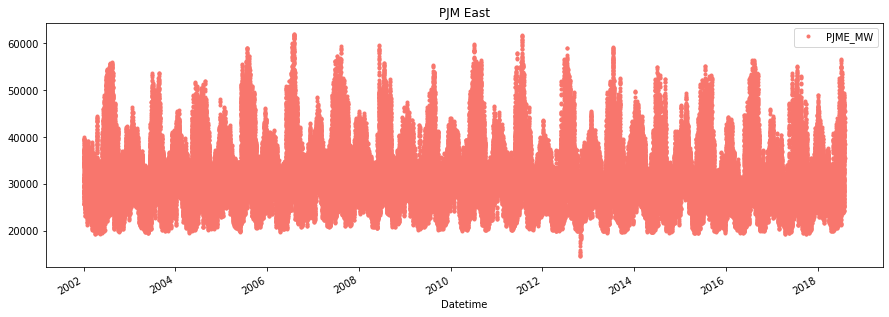

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
data.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [ ]:
# Creating time series features to analyze the data 
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [ ]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


<b> Now we can observe power demand depending on several characterics or trends: 
> 1. Power consumption may increase on weekends 
2. We can also try to observe seasonal trend if possible as mostly seasonal electronic equipments like AC's, refrigerators and Heaters have high seasonal use which may cause the increase in power demand.

<b> Plotting the features

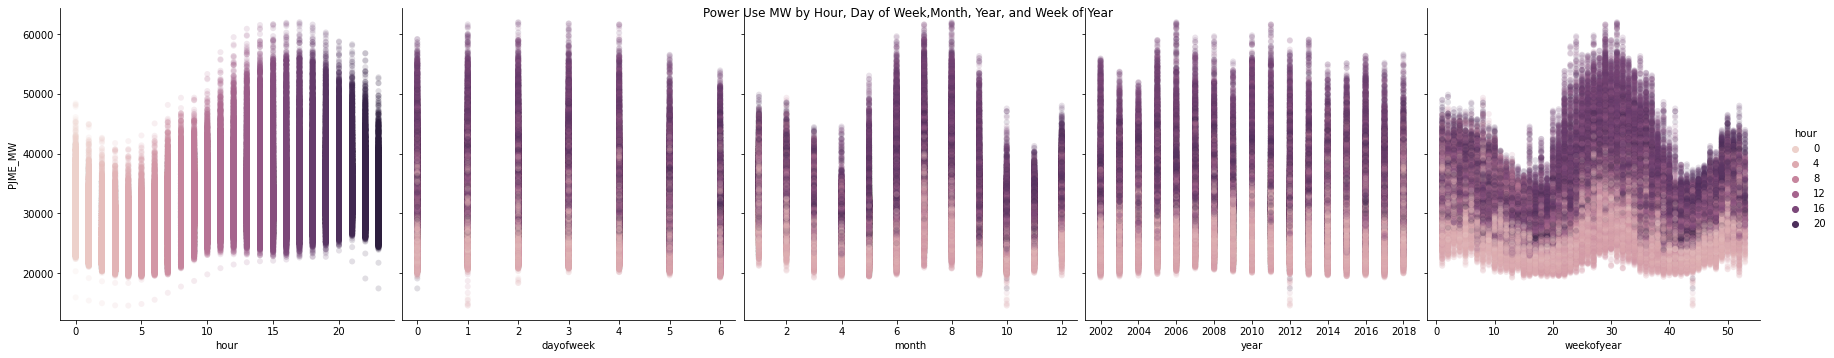

In [ ]:
drop_null_from_features=features_and_target.dropna()
sns.pairplot(drop_null_from_features,
             hue='hour',
             x_vars=['hour','dayofweek','month',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week,Month, Year, and Week of Year')
plt.show()

<B>Observations</b>

*   We can observe that there is peak usage of electricity in the last hours of the day.
*   We can also observe that there is peak usage of power demand in the hotter months from 5th to 9th.

*   Even the week of the year shows us that the highest demand is mostly in the weeks of the summer.

*   Year and day_of_the_week doesnot provide us great insights so we should further investigate into them.









## Train-Test Split of data
<b> As we have the data from 2001-2018 i.e. about 18 years of data so we would probably take the first 15 years of training data and the next 3 years of data as the test data. 

In [ ]:
# Here we will try to make a copy of the data so that the original data doesnot get altered.
# Here as we have the index positions as date so we will try to split the data based on these dates
split_date = '01-Jan-2015'
pjme_train = data.loc[data.index <= split_date].copy()
pjme_test = data.loc[data.index > split_date].copy()

In [ ]:
pjme_train.tail()

,PJME_MW
Datetime,
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0
2014-01-01 23:00:00,32215.0
2014-01-02 00:00:00,30159.0


In [ ]:
pjme_test.head()

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
2015-12-31 05:00:00,22773.0


<b> We can observe all the dates before 2015 are present in the train data and from 2015 are present in the test data

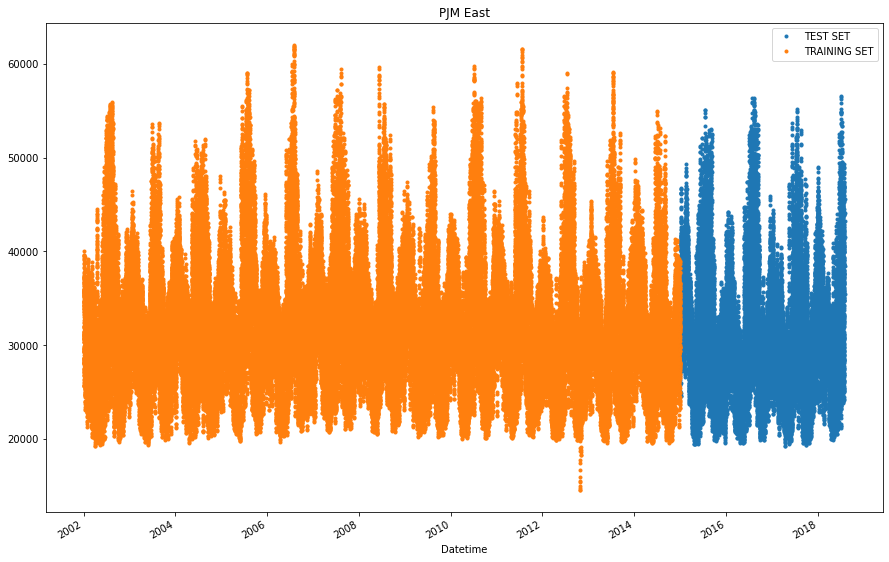

In [ ]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,10), title='PJM East', style='.')
plt.show()

## Using Prophet to train on the data
<b> Prophet requires to give data in a specific format, it needs the independent or data time feature to be named as "ds" and the dependent or target feature to be given as "y". So we will rename both our train and test data.

In [ ]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [ ]:
pjme_train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
# Format data for prophet model using ds and y
pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_test.head()

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
2015-12-31 05:00:00,22773.0


In [ ]:
# Will fit our simple Prophet on our train data
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

In [ ]:
# Predict or forecast on our test data
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31190.115784,23816.291879,32906.127885,31190.115784,31190.115784,-2820.067931,-2820.067931,-2820.067931,-4430.324151,-4430.324151,-4430.324151,1281.432109,1281.432109,1281.432109,328.824111,328.824111,328.824111,0.0,0.0,0.0,28370.047853
1,2015-01-01 02:00:00,31190.075956,22567.467653,31527.455553,31190.075956,31190.075956,-4324.359473,-4324.359473,-4324.359473,-5927.199911,-5927.199911,-5927.199911,1272.673300,1272.673300,1272.673300,330.167138,330.167138,330.167138,0.0,0.0,0.0,26865.716483
2,2015-01-01 03:00:00,31190.036128,21820.891626,30511.123218,31190.036128,31190.036128,-5196.010627,-5196.010627,-5196.010627,-6790.271265,-6790.271265,-6790.271265,1262.709009,1262.709009,1262.709009,331.551628,331.551628,331.551628,0.0,0.0,0.0,25994.025500
3,2015-01-01 04:00:00,31189.996300,20946.507764,30659.416861,31189.996300,31189.996300,-5337.553296,-5337.553296,-5337.553296,-6922.193706,-6922.193706,-6922.193706,1251.662803,1251.662803,1251.662803,332.977607,332.977607,332.977607,0.0,0.0,0.0,25852.443003
4,2015-01-01 05:00:00,31189.956472,22208.043305,31006.887304,31189.956472,31189.956472,-4663.215490,-4663.215490,-4663.215490,-6237.331039,-6237.331039,-6237.331039,1239.670450,1239.670450,1239.670450,334.445099,334.445099,334.445099,0.0,0.0,0.0,26526.740982


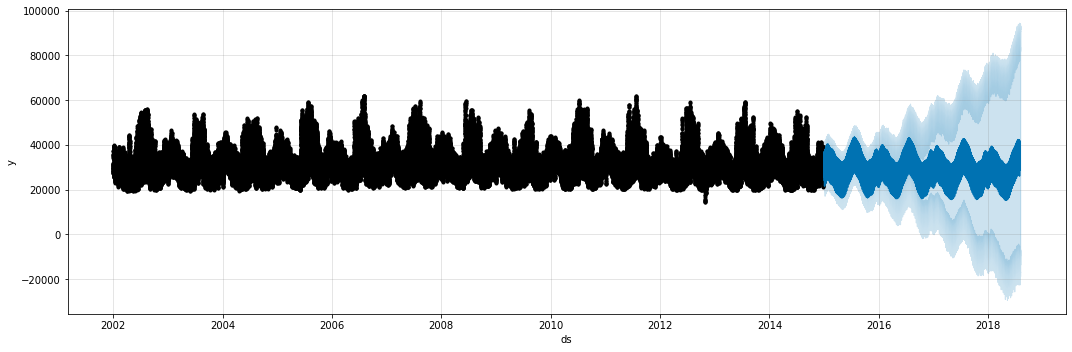

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

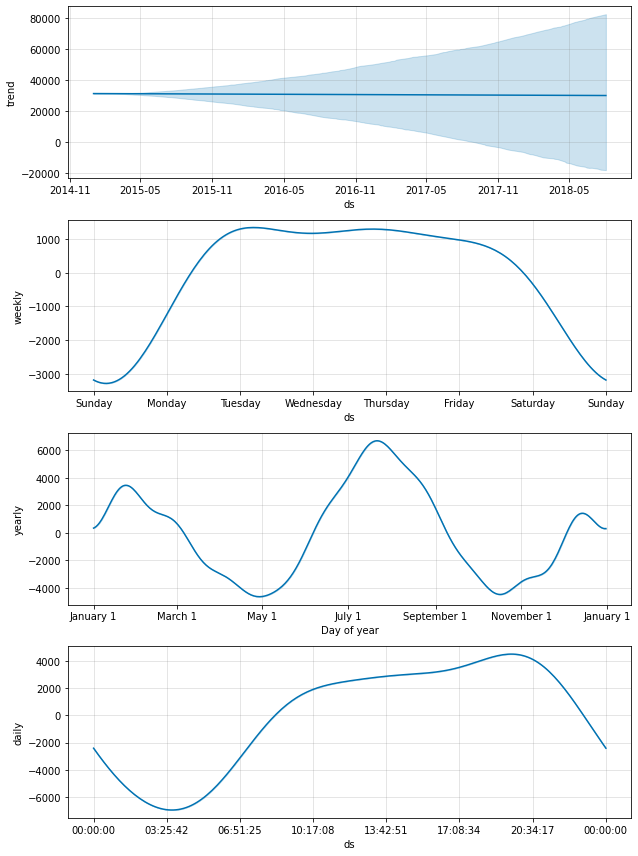

In [ ]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

<B> Comparing the Actuals with the Forecast Values.

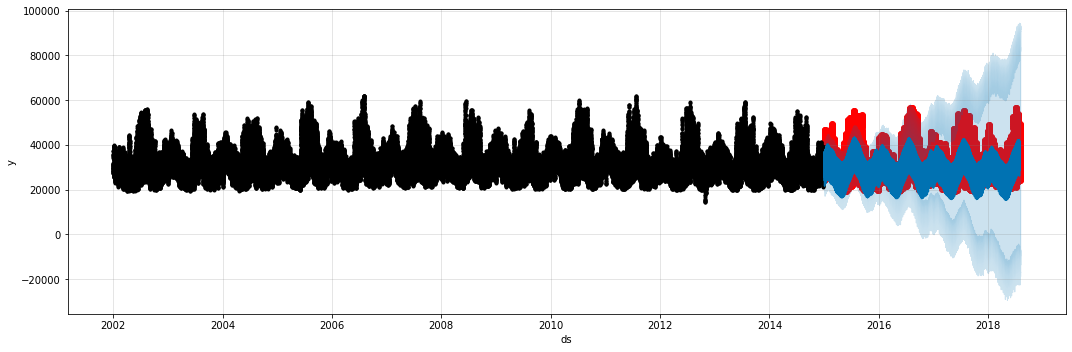

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r') # plotting he actual data as red
fig = model.plot(pjme_test_fcst, ax=ax)   # Plotting the forecasted values as blue

## <B>Let us try to visualize the first month predictions and compare it with Actuals

<b> First Month January 2015 forecast

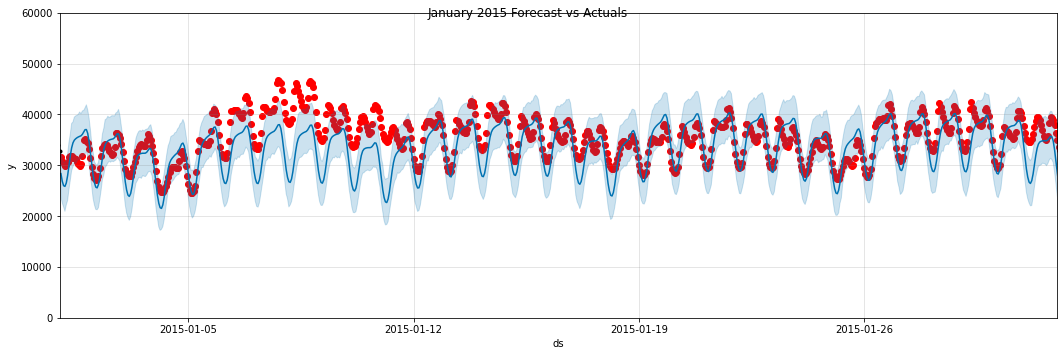

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 2, 1)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

<b> Peak month June forecast 2015

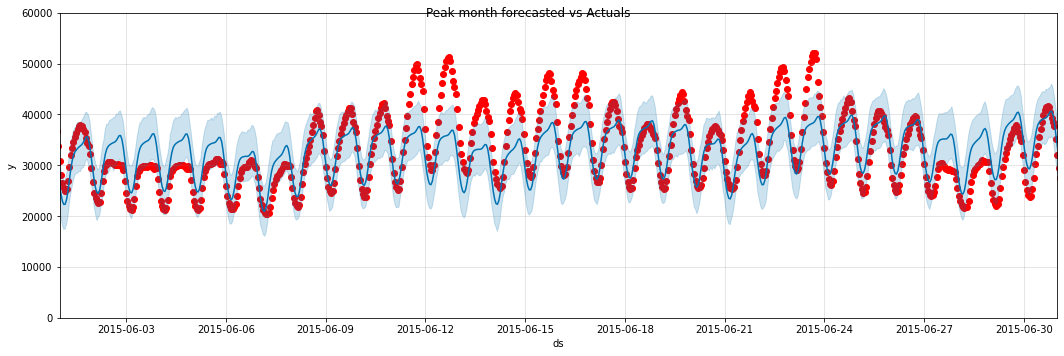

In [ ]:
# Plot the forecast with the actuals

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 6, 1), datetime.date(2015, 7, 1)])  # yr-mon-day
ax.set_ylim(0, 60000)
plot = plt.suptitle('Peak month forecasted vs Actuals')

<b> First week of january forecast

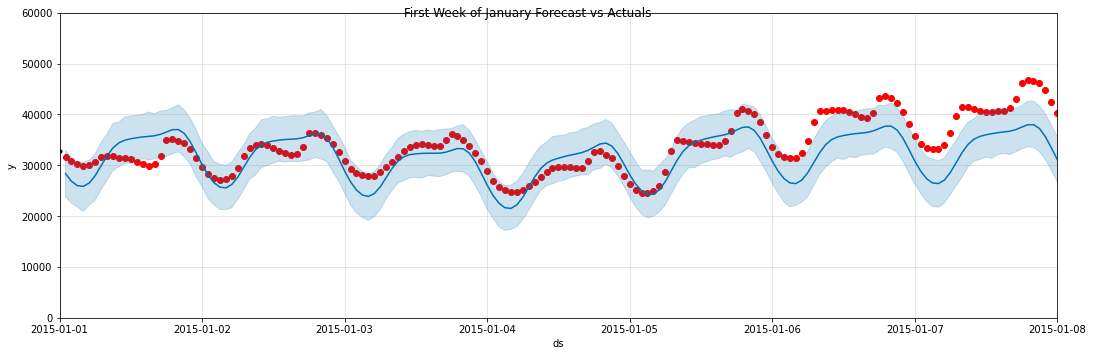

In [ ]:
# Plot the forecast with the actuals

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 1, 8)])  # yr-mon-day
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

43851823.35057676

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5185.54679246028

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.503989655716325

<b>Error Metrics</b>

*   Mean-squared-error: 43851823.351
*   Mean-absolute-error: 5185.546
*   MAE percentage: 16.5%
> We can observe that the error rate is very high so we will try to check if holidays has an influence with the power consumption so we will try to add holidays of US to the model. As Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.<br>
We will try to add the holidays list that is already provided in pandas as `USFederalHolidayCalendar`.






In [ ]:
pjme_train.index.min(), pjme_train.index.max()

(Timestamp('2002-01-01 01:00:00'), Timestamp('2015-01-01 00:00:00'))

In [ ]:
pjme_test.index.min(), pjme_test.index.max()

(Timestamp('2015-01-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

Here we will generate the holidays differently for both train and test data from the start date to the end date holidays.

In [ ]:
# importing the usfederalholidaycalendar and generating the holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [ ]:
# Create a dataframe with holiday, ds columns
data['date'] = data.index.date                                                            # getting the index dates from the data
data['is_holiday'] = data.date.isin([d.date() for d in cal.holidays()])                                   # getting the days with the holidays from our holidays calendar
holiday_df = data.loc[data['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])  # converting the column to datetime

## Train the Prophet model with holidays

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

<b> Forecasting on the test data with holidays

In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

<b> Plotting the components of the holiday effect

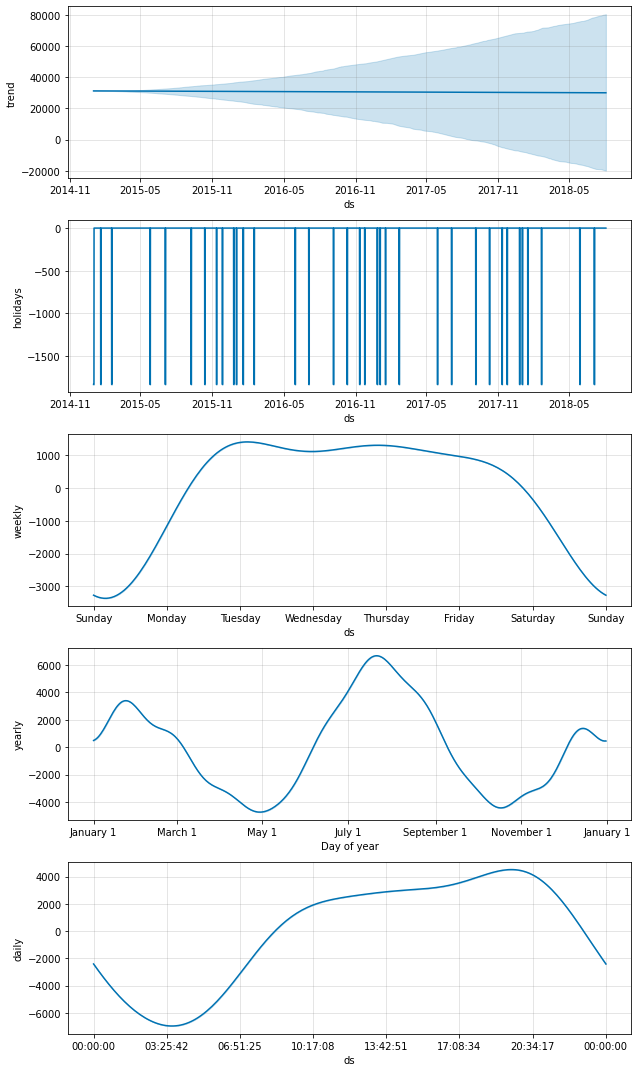

In [ ]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

<b> Error Metrics after including holidays

In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43928062.03151226

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5192.206782840753

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.539529017089176

<b> We could observe that the error rate has increased after we have added the holidays 

<b> Let us compare the model only for holidays</b>
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

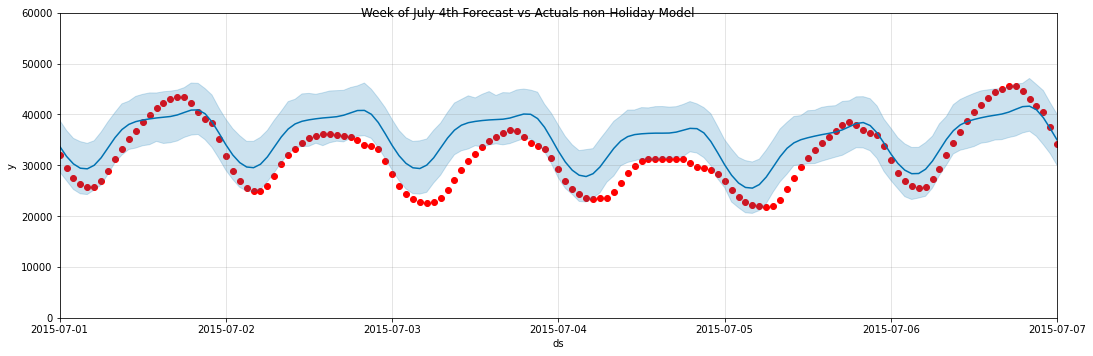

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim([datetime.date(2015, 7, 1), datetime.date(2015, 7, 7)])  # yr-mon-day
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

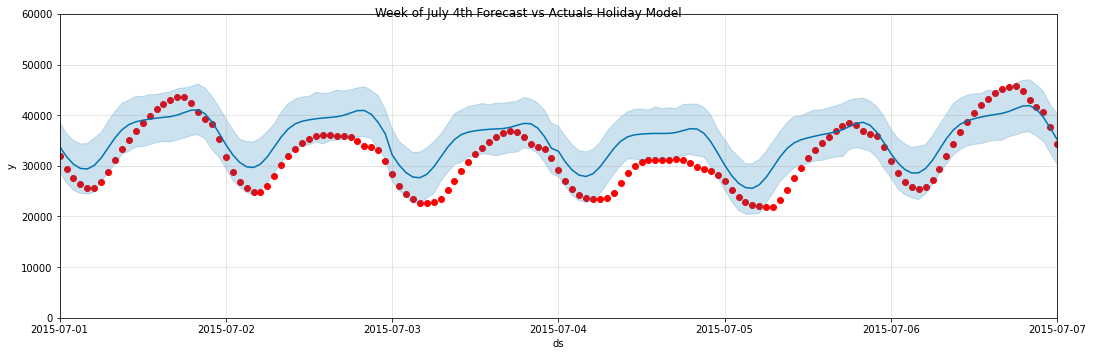

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xlim([datetime.date(2015, 7, 1), datetime.date(2015, 7, 7)])  # yr-mon-day
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

<b> Calculating the error metrics only for this date

In [ ]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [ ]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2153.7284326547356

In [ ]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2154.6261571056853

<b> We can observe Holiday has more error as compared to non-holiday

<b> Calculating error for all the holidays 

In [ ]:
holiday_list = holiday_df['ds'].tolist()

In [ ]:
hols_test = pjme_test.query('Datetime in @holiday_list') # we are taking all the dates of holidays that are present in test data
hols_pred = pjme_test_fcst.query('ds in @holiday_list')  # # we are taking all the dates of holidays that are present in forecasted data
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list') # # we are taking all the dates of holidays that are present in forecasted withh holidays data

In [ ]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5232.115798607173

In [ ]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5125.940383436851

<b> We can observe that error the model with only holidays has increased and gone up

## Identify Error by holiday
>We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

In [ ]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3099.2 
 MAE (Holiday Model): 2673.3 
 Diff 425.8
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2423.9 
 MAE (Holiday Model): 2088.2 
 Diff 335.7
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11084.8 
 MAE (Holiday Model): 12730.2 
 Diff -1645.4
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1549.4 
 MAE (Holiday Model): 1630.3 
 Diff -80.9
Holiday: July 03, 2015:    
 MAE (non-holiday model): 5976.6 
 MAE (Holiday Model): 4257.1 
 Diff 1719.5
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.7 
 MAE (Holiday Model): 4349.3 
 Diff -497.6
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1568.4 
 MAE (Holiday Model): 1902.3 
 Diff -333.8
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2023.0 
 MAE (Holiday Model): 1586.3 
 Diff 436.7
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4646.0 
 MAE (Holiday Model): 3780.0 
 Diff 865.9
Holiday: December 25, 2015:    


## Plot Error of Each Forecast
>We can see that both of our models generalize well, but struggle with peak demand days.
Seems to be under forecasting many days

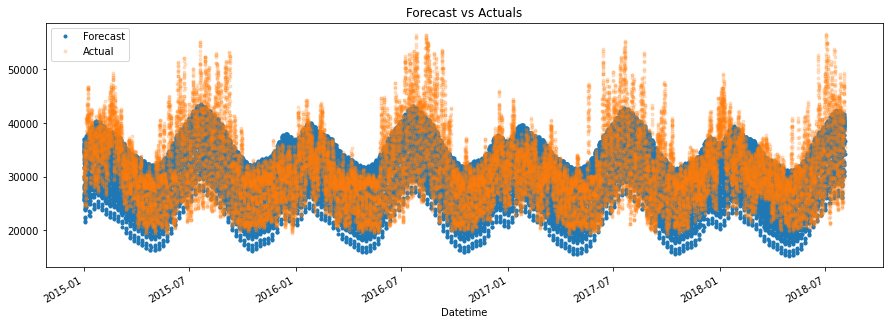

In [ ]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0, 
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

<b> We can observe that there is some presence of grabage values in our data which needs to be cleared so our next step would be data cleaning. The garbage values can be seen from the orange dots moving outwards in the above plot.

## Data Cleaning
>Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.<br>
>We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.


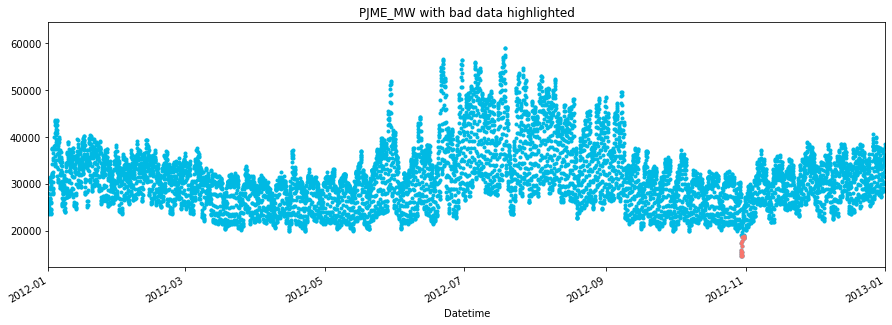

In [ ]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()


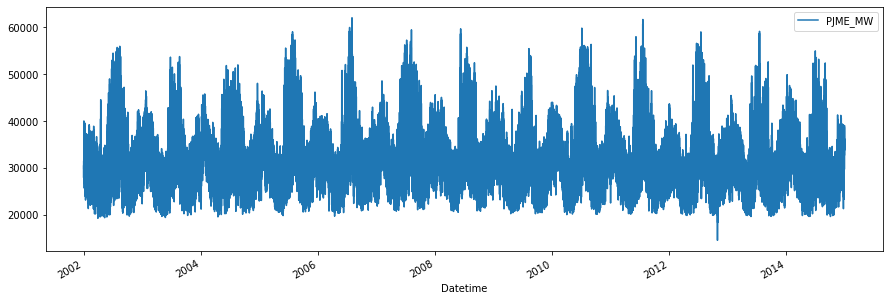

In [ ]:
pjme_train.plot(figsize=(15, 5))
plt.show()

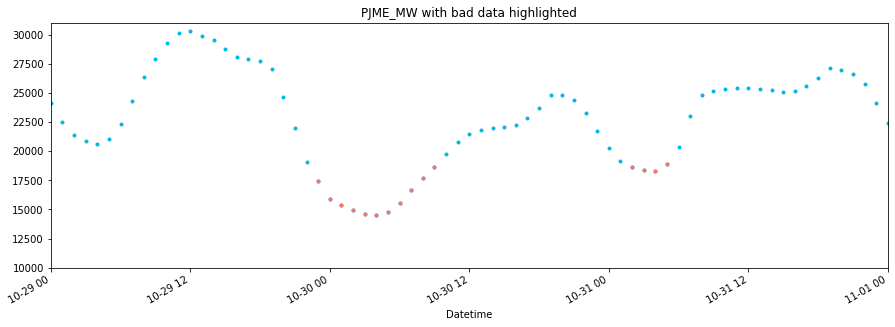

In [ ]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

<b> We can observe that there is sudden dip in the energy outsage so we neeed to even check externally what could be the reasons for this drop in energy in that time in `2012`<br>
When we look into the wikipedia articles for that year[Power Outsages](https://en.wikipedia.org/wiki/List_of_major_power_outages#2012) we observed that this occured due to hurricance sandy which hit the area in the end of october.
> On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. The storm, which came ashore near Atlantic City, New Jersey as a Category 1 hurricane, ultimately left scores of homes and businesses without power in New Jersey (2.7 million), New York (2.2 million), Pennsylvania (1.2 million), Connecticut (620,000), Massachusetts (400,000), Maryland (290,000), West Virginia (268,000), Ohio (250,000), and New Hampshire (210,000). Power outages were also reported in a number of other states, including Virginia, Maine, Rhode Island, Vermont, and the District of Columbia

In [ ]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43819560.7138 - MAE 5183.5584 - MAPE 16.5043


<b> After cleaning the data we can observe that there is slight improvement in the score as compared to the first model

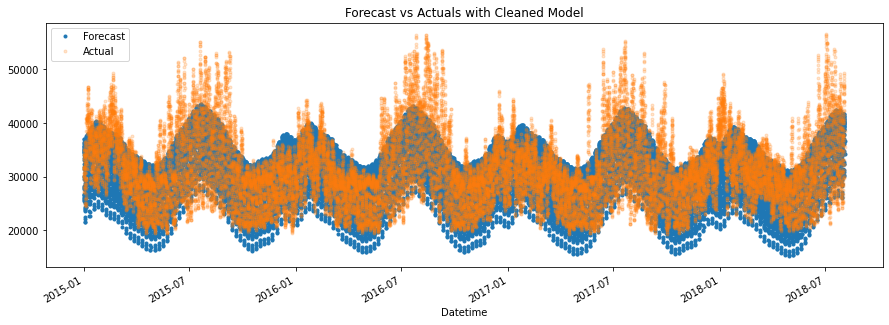

In [ ]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()

<b> Trying to tune the paramerters

In [ ]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1,changepoint_prior_scale=0.5)
model.add_country_holidays(country_name='US')
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 44030050.3128 - MAE 5200.6536 - MAPE 16.5501


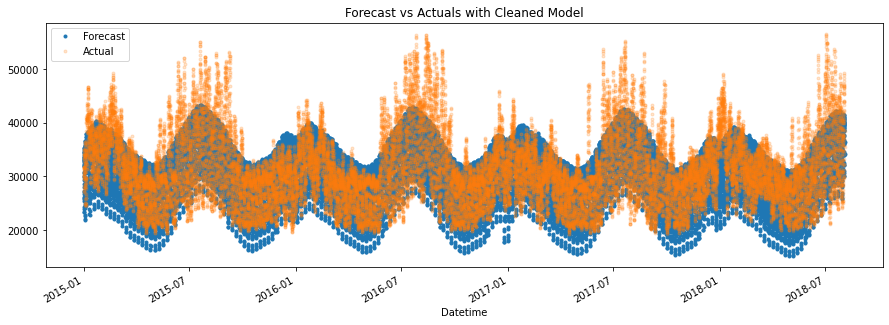

In [ ]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()

## Further Improvements
>1. We should try to get a better holiday list as logically, holidays should increase the energy usage but our model doesnot logically seem to analyze it as there may be some special characteric of holidays which have caused more impact from 2001-2018 and also the natural calamity days like Hurricane or other storms or cyclones which has caused havoc and no enrgy usage for several days due to unavailabilty.
2.  We should also try to tune the model more inorder to get the correct checkpoints and observe the fourier order of seasonality.
3.  We need to even take into a important factor which is uncertainity of trend.